### Tree Cover Calculation

Understanding how much of an area is covered by trees is a central question in ecology.  
Tree cover influences local climate by moderating temperature extremes, maintaining humidity, and shaping precipitation patterns. It also serves as a baseline variable for studies of biodiversity, carbon cycling, and habitat connectivity.  

However, the **choice of input data** has a major influence on the calculated tree cover.  
This notebook demonstrates why that choice matters,showing how results can shift depending on a dataset’s spatial resolution and classification scheme.

This notebook has three main goals:

1. **Visualize the study site** — display a high-resolution image to provide spatial context.  
2. **Calculate tree cover** within the study area using two global datasets that differ in spatial resolution and land-cover classification.  
3. **Compare results** to illustrate how dataset choice affects estimates of forest extent and interpretations of landscape structure.


In [ ]:
# Kernel check (useful sanity check)
import sys
print("Kernel Python:", sys.executable)

# Modules used in project
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from geo_northarrow import add_north_arrow
import requests  # missing import fixed

# Earth Engine / Geemap
import ee
import geemap

# Images
from PIL import Image

# Final Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams


In [ ]:
# Load and rename columns properly
df = pd.read_csv("YOUR_CVS_FILE")
# Give Columns shorter names
df.rename(columns={"Longitude_Centroid": "long", "Latitude_Centroid": "lat"}, inplace=True)
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["long"], df["lat"]))

# Assign CRS to that of your data mine is WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Print CRS info
print(gdf.crs)

EPSG:4326


### Defining the Study Area

Next, we create a **bounding box** that outlines the extent of the study area based on the GPS coordinates of the sampling points.  

This bounding box provides a simple way to define the spatial limits for all subsequent analyses and ensures that every dataset we use covers exactly the same region.

We extract the minimum and maximum longitude and latitude values from the coordinate data and use them to build a rectangular polygon (EPSG:4326, WGS84).

This step gives us a clearly defined area of interest (AOI) for later calculations of forest cover and comparisons across datasets.


In [3]:
# Create a bounding box epsg=4326
minx, miny, maxx, maxy = gdf.total_bounds
study_area = Polygon([
    (minx, miny),
    (minx, maxy),
    (maxx, maxy),
    (maxx, miny),
    (minx, miny)])


### Visual Check of Sampling Sites

Before proceeding, it’s useful to **plot the sampling sites on a simple background** to confirm that the spatial extent looks reasonable and that the points fall where they should.  

This step is most informative if you’re already familiar with the study area, but even if the data were collected by someone else, it’s still worth doing.  
Check the raw data first to ensure that the extent is consistent with the input data.


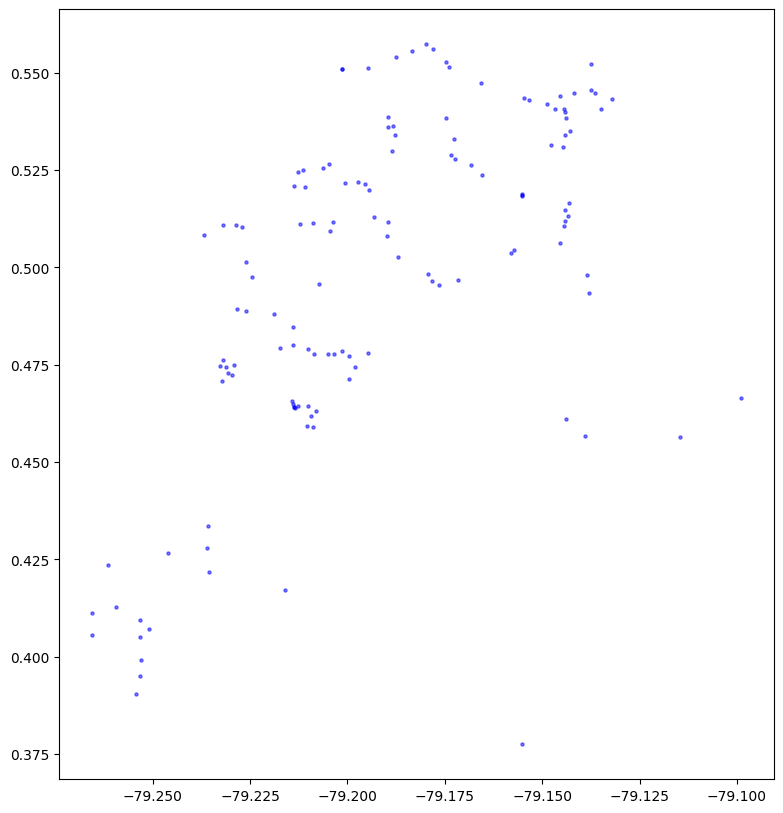

In [4]:
# Reality check
ax = gdf.plot(figsize=(10, 10), 
              color='blue', 
              markersize=5, 
              alpha=0.5)

### Reference Imagery

To provide spatial context, we use **World Imagery** from [**ArcGIS Online**](https://www.arcgis.com/home/item.html?id=10df2279f9684e4a9f6a7f08febac2a9) to create a high-resolution **reference image** of the study area.  
This basemap, produced by *Esri*, *Maxar*, *Earthstar Geographics*, and the *GIS User Community*, offers detailed satellite and aerial imagery that helps visualize the landscape before performing any analysis.


In [5]:
# Define the URL for the MapServer metadata endpoint
url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer?f=json"

# Make the request
response = requests.get(url)

# Check if the response is valid JSON
if response.status_code == 200:
    try:
        data = response.json()
        print(data)  # Print the metadata
    except requests.exceptions.JSONDecodeError:
        print("The response is not valid JSON.")
else:
    print(f"Error: {response.status_code}")

{'currentVersion': 11.3, 'cimVersion': '3.3.0', 'serviceDescription': "<div style='text-align:Left;font-size:12pt'><p><span>World Imagery provides one meter or better satellite and aerial imagery in many parts of the world and lower resolution satellite imagery worldwide. The map includes 15m TerraColor imagery at small and mid-scales (~1:591M down to ~1:288k) for the world. The map features Maxar imagery at 0.3m resolution for select metropolitan areas around the world, 0.5m resolution across the United States and parts of Western Europe, and 1m resolution imagery across the rest of the world. In addition to commercial sources, the World Imagery map features high-resolution aerial photography contributed by the GIS User Community. This imagery ranges from 0.3m to 0.03m resolution (down to ~1:280 in select communities). For more information on this map, including the terms of use, visit us online at https://goto.arcgisonline.com/maps/World_Imagery</span></p></div>", 'mapName': 'Layers'

In [6]:
# Define the URL for the Export Map endpoint
url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export"
bbox_str = f"{minx:.6f},{miny:.6f},{maxx:.6f},{maxy:.6f}"
params = {
    "bbox": bbox_str,
    "bboxSR": "4326",
    "size": "800,600",  # Width and height of the image
    "imageSR": "4326",  # Spatial reference of the image
    "format": "png",  # Image format
    "f": "image",  # Response format
}

response = requests.get(url, params=params)

# define folder to save image
out_dir = "outputs"

# Save the image to a file
if response.status_code == 200:
    print("Response Headers:", response.headers)
    print("Content-Type:", response.headers.get("Content-Type"))
    if "image" in response.headers.get("Content-Type", ""):
        out_path = out_dir + "/WorldImagery_StudySite.png"  # (note: You can change the file name)
        print(out_path)
        with open(out_path, "wb") as f:
            f.write(response.content)
        print("Image saved as WorldImagry_StudySite.png")
    else:
        print("The response is not an image.")
else:
    print(f"Error: {response.status_code}, {response.text}")

Response Headers: {'Content-Type': 'image/png', 'Content-Length': '344231', 'Connection': 'keep-alive', 'Date': 'Sun, 19 Oct 2025 18:23:17 GMT', 'Server': '', 'Cache-Control': 'max-age=0,must-revalidate', 'X-Content-Type-Options': 'nosniff', 'Vary': 'Origin', 'ETag': '"63d6518c"', 'Access-Control-Allow-Origin': '*', 'X-Robots-Tag': 'noindex', 'X-Cache': 'Miss from cloudfront', 'Via': '1.1 d63d8d406be99e2ae197739e9767d67e.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'FRA56-P14', 'X-Amz-Cf-Id': 'rncf4n4_oxGwCGJyG-dC03sa4f0ehgUX27cyn4L60LvtYTuMB81UPA=='}
Content-Type: image/png
outputs/WorldImagery_StudySite.png
Image saved as WorldImagry_StudySite.png


### Adding Map Elements

Next, we enhance the reference image by adding key map elements for spatial orientation and interpretation.  
A **scale bar** provides a sense of distance, while a **north arrow** helps indicate direction.  
Finally, we overlay the **individual sampling sites** to show their distribution within the study area.  
Together, these elements make the map more informative and suitable for presentation or publication.


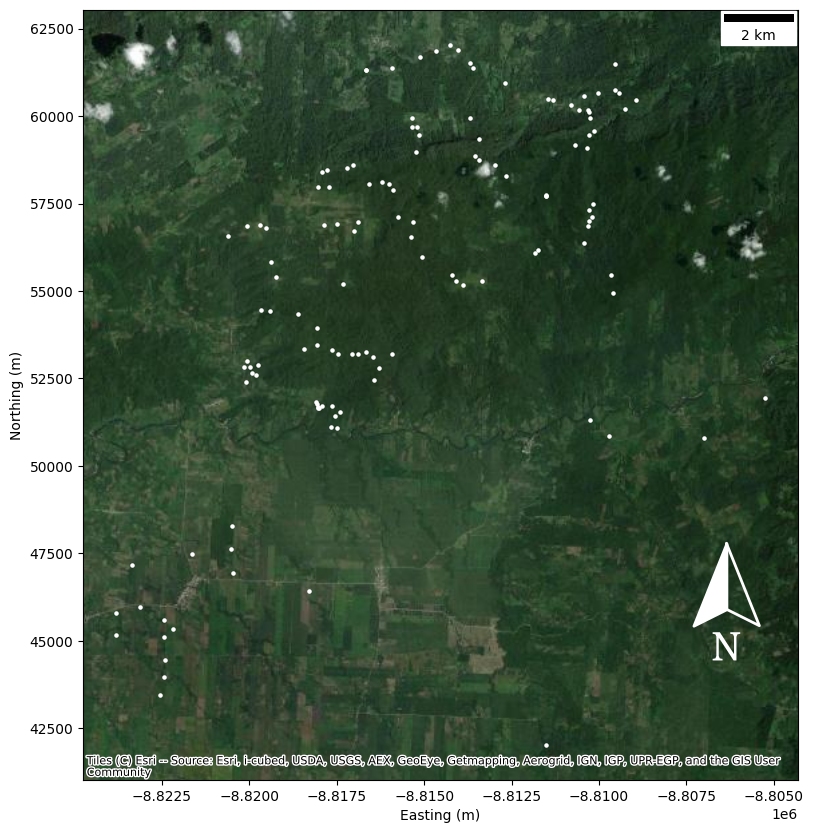

In [7]:
# # Load the image
# image_path = "WorldImagry_StudySite.png"
# img = mpimg.imread(image_path)

gdf = gdf.to_crs(epsg=3857) # the base map cannot be added if this is not set
# Plot the image
ax = gdf.plot(figsize=(10, 10), color='white', markersize=5, alpha=1) # set alpha to 0.0 to hide the points

# add the scale bar
scalebar = ScaleBar(1, units='m', location='upper right')
ax.add_artist(scalebar)
# add the north arrow
add_north_arrow(ax=ax, ylim_pos=.2, color="white",text_scaler=2.5, text_yT=-1.25)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Add a background map see 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)


So here we have a clear and readable base map with our sampling points. We can now visually see what our area of interest looks like and use it as a reality check for everything we do later, when we calculate the area covered by trees using different data products.

# Interactive Maps

Interactive maps allow us to explore the data dynamically rather than relying solely on static figures.  
By zooming and panning around the study area, we can better understand how tree cover patterns align with topography, land use, and sampling locations.  
These maps also make it easier to compare datasets side by side and visually inspect differences in spatial resolution and classification.


### MODIS Tree Cover (Google Earth Engine)

First, let’s use [**Google Earth Engine**](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).

Google Earth Engine is a powerful and flexible platform for tackling a wide range of geospatial problems. It has its own syntax, but the output is intuitive and well-suited for large-scale spatial analysis.

It provides easy access to MODIS data products, and its cloud-based approach allows for relatively fast processing.  
Here, we use the [**MODIS Land Cover Type Yearly**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1) dataset.  
The data have a spatial resolution of 500 m and include several bands representing land-cover classes.  
We use the **LC_Type1** band, which contains 17 classes, and consider the first five to represent tree cover.


In [8]:
# check that the package in loaded
print(ee.__version__)

1.5.23


In [ ]:
# First step in to authenticate with Earth Engine
ee.Authenticate()
ee.Initialize(project='YOUR_PROJECT_ID')


In [10]:
# Region of Interest for Earth Engine
ee_study_area = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# Load the MODIS land cover image
landcover = ee.ImageCollection("MODIS/061/MCD12Q1") \
    .filterDate("2019-01-01", "2019-12-31") \
    .first() \
    .select("LC_Type1")

# Define forest classes (1–5 = forest types in IGBP scheme)
forest = landcover.lt(6)  # forest if LC_Type1 value is 1–5 lt = less than

# Calculate forest area in square meters
pixel_area = ee.Image.pixelArea()
forest_area_image = pixel_area.updateMask(forest)

# Sum forest area in ROI
forest_area_stats = forest_area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=ee_study_area,
    scale=500,
    maxPixels=1e13
)

forest_area_m2 = forest_area_stats.get("area").getInfo()  
forest_area_km2 = forest_area_m2 / 1_000_000 if forest_area_m2 else None

# Total area of ROI
total_area_stats = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= ee_study_area,
    scale=500,
    maxPixels=1e13
)

total_area_m2 = total_area_stats.get("area").getInfo()
total_area_km2 = total_area_m2 / 1_000_000 if total_area_m2 else None

# Percent forest cover
forest_percent = (forest_area_km2 / total_area_km2 * 100) if forest_area_km2 and total_area_km2 else None

print(f"Forest area: {forest_area_km2:.2f} km\u00B2")
print(f"Total area: {total_area_km2:.2f} km\u00B2")
print(f"Forest cover: {forest_percent:.2f}%")

Forest area: 104.80 km²
Total area: 370.11 km²
Forest cover: 28.31%


In [11]:
# Define Study Area Center 
lon, lat = ee_study_area.centroid().coordinates().getInfo()
print(lat,lon)

0.46742860211873616 -79.18228099999943


In [ ]:

# Create a Map
Map = geemap.Map(center= [lat,lon], zoom=12)
Map.addLayer(landcover.clip(ee_study_area), {
    'min': 0,
    'max': 17,
    'palette': ['black'], 
}, 'Study Area')
Map.addLayer(forest.updateMask(forest), {'palette': ['darkgreen']}, 'Forest mask')
Map.addLayer(ee.Image().paint(ee_study_area, 0, 2), {'palette': ['gray']}, 'Study Area Boundary')
Map.addLayerControl()
Map


### ESA WorldCover (10 m)

Next, let’s use the [**ESA WorldCover**](https://esa-worldcover.org/en) dataset for 2020–2021.

ESA WorldCover provides global land-cover maps at **10 m spatial resolution**, derived from Copernicus Sentinel-1 and Sentinel-2 data.  

We use the 2020 product because it aligns most closely with the period of our field sampling. This choice matters because the 2021 dataset uses a different **algorithm** for land-cover classification.

This dataset offers much finer spatial detail than MODIS, making it particularly useful for analyzing heterogeneous or fragmented landscapes.  
The higher resolution also allows for more accurate estimates of forest extent at local scales.

---

**Attribution (as required by ESA):**  
© ESA WorldCover project 2020 / Contains modified Copernicus Sentinel data (2020) processed by the ESA WorldCover consortium.

**Citation:**  
Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A., Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, L., Tsendbazar, N.E., Ramoino, F., & Arino, O. (2021).  
*ESA WorldCover 10 m 2020 v100.*  
[https://doi.org/10.5281/zenodo.5571936](https://doi.org/10.5281/zenodo.5571936)

In [13]:
# Load ESA WorldCover (2020 version) 
landcover = ee.Image("ESA/WorldCover/v100/2020")

# Forest class code: 10
forest = landcover.eq(10) # make all forest pixels equal to 1, others to 0

# Pixel area image (10m resolution)
pixel_area = ee.Image.pixelArea()

# Mask pixel area to forest only
forest_area_image = pixel_area.updateMask(forest)

# Calculate forest area in your ROI
forest_stats = forest_area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=ee_study_area,
    scale=10,
    maxPixels=1e13
)

forest_area_m2 = forest_stats.get("area").getInfo()
forest_area_km2 = forest_area_m2/1_000_000
print(forest_area_km2)


318.38190105010574


In [14]:
total_area_stats = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=ee_study_area,
    scale=10,
    maxPixels=1e13
)
total_area_m2 = total_area_stats.get("area").getInfo()
total_area_km2 = total_area_m2/1_000_000 if total_area_m2 else None

# Percent forest cover
forest_percent = (forest_area_m2 / total_area_m2 * 100) if forest_area_m2 and total_area_m2 else None

print(f"Forest area: {forest_area_km2:.2f} km\u00B2")
print(f"Total area: {total_area_km2:.2f} km\u00B2")
print(f"Forest cover: {forest_percent:.2f}%")


Forest area: 318.38 km²
Total area: 369.22 km²
Forest cover: 86.23%


In [ ]:
# Create Map
Map = geemap.Map(center= [lat,lon], zoom=12)

# Add full landcover for context
Map.addLayer(landcover.clip(ee_study_area), {
    'min': 10,
    'max': 100,
    'palette': ['black'],
}, "Study Area")

# Add forest-only layer
Map.addLayer(forest.updateMask(forest), {'palette': ['darkgreen']}, "Forest Mask (ESA)")
# Add boundary
Map.addLayer(ee.Image().paint(ee_study_area, 0, 2), {'palette': ['gray']}, 'Study Area Boundary')
Map.addLayerControl()
Map


Now we have all our outputs, it would be nice to view them side by side for easier iinterpretation.

In [16]:
#help(geemap.ee_export_image)

In [17]:
# Get size of satelite referance image
im = Image.open('outputs/WorldImagery_StudySite.png')
print(im.size)
dim = im.size
type(dim)

(800, 600)


tuple

In [ ]:
# First ensure we're working with WGS84 coordinates
gdf_wgs = gdf.to_crs(epsg=4326)
minx, miny, maxx, maxy = gdf_wgs.total_bounds
ee_study_area = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# --- Export both forest masks ---
# MODIS forest mask (500 m)
modis = ee.ImageCollection("MODIS/061/MCD12Q1") \
    .filterDate("2019-01-01", "2019-12-31") \
    .first() \
    .select("LC_Type1")
modis_forest = modis.lt(6).selfMask()  # Classes 1-5 are forest
modis_vis = modis_forest.visualize(**{
    'min': 0,
    'max': 1,
    'palette': ['darkgreen']
})

# ESA WorldCover forest mask (10 m)
esa = ee.Image("ESA/WorldCover/v100/2020")
esa_forest = esa.eq(10).selfMask()  # Class 10 is forest
esa_vis = esa_forest.visualize(**{
    'min': 0,
    'max': 1,
    'palette': ['darkgreen']
})

# Add study area boundary to both
# outline = ee.Image().paint(ee_study_area, 0, 2)
# outline_vis = outline.visualize(**{'palette': ['gray']})

# modis_final = modis_vis.blend(outline_vis)
# esa_final = esa_vis.blend(outline_vis)

# Export both images
geemap.ee_export_image(
    modis_vis,
    filename="outputs/modis_forest.tif",
    region=ee_study_area#,
    #dimensions=[800, 600]
)

geemap.ee_export_image(
    esa_vis,
    filename="outputs/esa_forest.tif", 
    region=ee_study_area#,
    #dimensions=[800, 600]
)



I now have local copies of the images above and can plot them side by side for comparison.

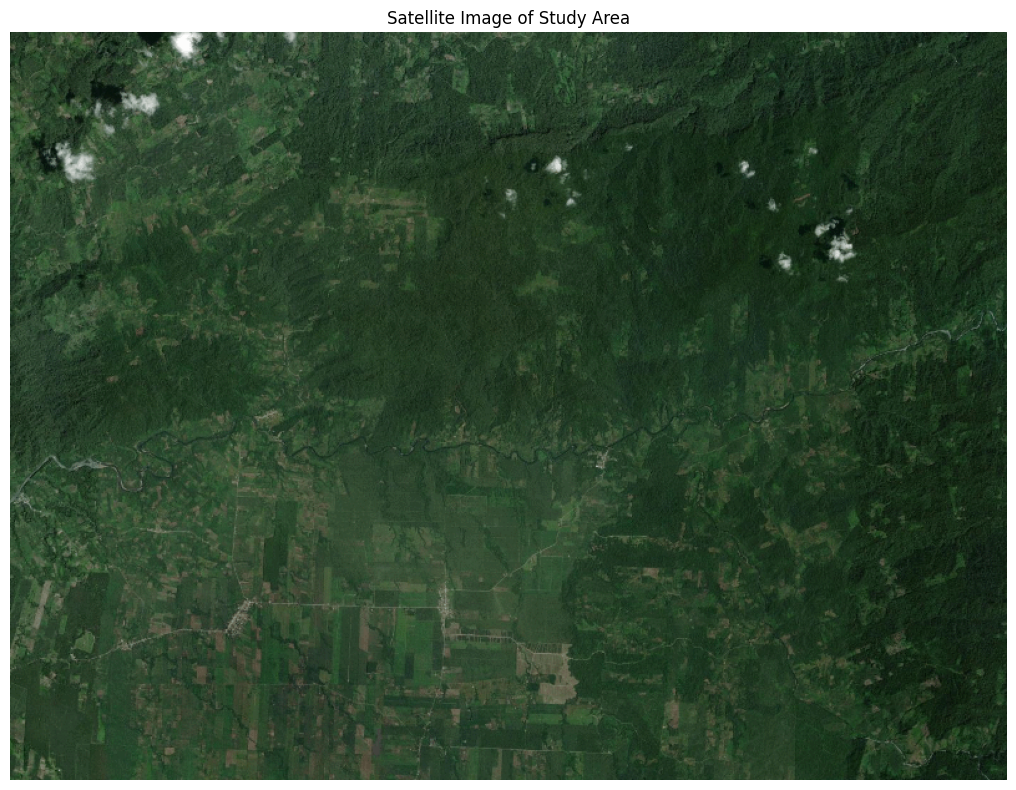

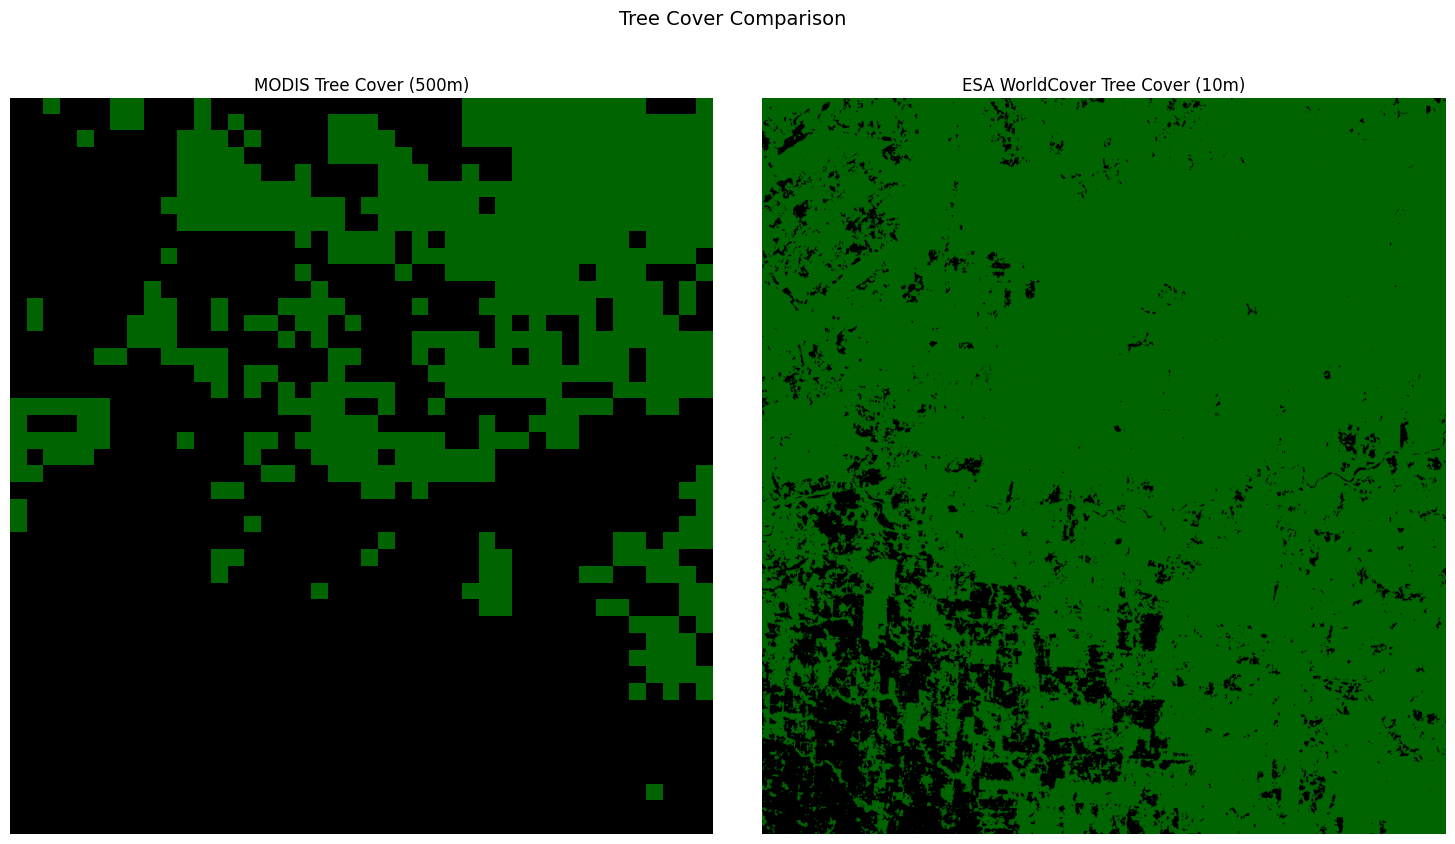

In [19]:
# Plot Reference 
fig = plt.figure(figsize=(15, 8))

# Load Image
sat_img = mpimg.imread('outputs/WorldImagery_StudySite.png')

plt.imshow(sat_img)
plt.title('Satellite Image of Study Area')
plt.axis('off')

# Add title
plt.tight_layout()
plt.show()

# Plot masked data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Load and display images

modis_img = mpimg.imread('outputs/modis_forest.tif')
esa_img = mpimg.imread('outputs/esa_forest.tif')

ax1.imshow(modis_img)
ax1.set_title('MODIS Tree Cover (500m)')
ax1.axis('off')

ax2.imshow(esa_img)
ax2.set_title('ESA WorldCover Tree Cover (10m)')
ax2.axis('off')

plt.suptitle('Tree Cover Comparison', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()


### Visual Comparison of Tree Cover Estimates

The area shown in the images covers approximately **370 km²**.  
A large portion of the **upper right** appears densely tree-covered, while the **lower left** contains noticeably less forest in the satellite image from World Imagery.  
This spatial pattern is reflected in both output maps, where **green** indicates tree cover and **black** represents all other land-cover types.

Placing the **MODIS** and **ESA WorldCover** products side by side makes the difference in resolution and classification readily apparent.  
The **MODIS** dataset estimates **105 km²** of tree cover (about **28%** of the total area), whereas the **ESA** dataset estimates **318 km²** (approximately **86%**).  
This contrast highlights how data resolution and classification methods can dramatically affect forest-cover estimates and their ecological interpretation.


In [20]:
#Map.save("forest_map.html")

In [21]:
# To save the notebook as HTML
# Uncomment the line below to run in a Jupyter environment

#!jupyter nbconvert --to html ForestArea.ipynb
